# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Bandit-Convex-Optimization" data-toc-modified-id="Bandit-Convex-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bandit Convex Optimization</a></div><div class="lev1 toc-item"><a href="#Set-up" data-toc-modified-id="Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set-up</a></div><div class="lev2 toc-item"><a href="#Defining-actions" data-toc-modified-id="Defining-actions-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Defining actions</a></div><div class="lev3 toc-item"><a href="#Ideas-for-how-to-define-the-actions-and-their-associated-losses" data-toc-modified-id="Ideas-for-how-to-define-the-actions-and-their-associated-losses-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Ideas for how to define the actions and their associated losses</a></div>

# Bandit Convex Optimization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fractions import Fraction

In [3]:
def SimpleMultiArmedBandit(n, T, delta, algOCO, actionLoss, **parms):
    """
    Simple multi-armed bandit algorithm
    """
    init = parms.get('init', {})
    ogdProj = parms.get('ogdProj', ProjSimplex)
    ogdStep = parms.get('ogdStep', .1)
    alVerbose = parms.get('actionLossVerbose', False)

    fHat = np.zeros(T)
    fHat[0] = init.get('fHat0', 0)
    x = np.zeros((n, T+1))
    x[:, 0] = init.get('x0', np.ones(n) / n)
    ellHat = np.zeros((n, T))
    ellHat[:, 0] = init.get('ellHat0', np.zeros(n))

    selectedActionNumber = np.zeros(T, dtype=np.int)
    observedLoss = np.zeros(T)

    for t in range(T):
        if (np.random.rand(1) > delta):
            selectedActionNumber[t] = np.random.randint(n)
            # print(x[:, t])
            observedLoss[t] = actionLoss(selectedActionNumber[t], n,
                                         t=t, T=T, x=x[:, t],
                                         verbose=alVerbose)
            ellHat[selectedActionNumber[t], t] = n * observedLoss[t] / delta
            fHat[t] = np.dot(ellHat[:, t], x[:, t])
            x[:, t+1] = algOCO(x[:, t], lambda x: ellHat[:, t],
                               Proj=ogdProj, eta=ogdStep)
        else:
            selectedActionNumber[t] = np.random.choice(np.arange(n, dtype=np.int), p=x[:, t])
            x[:, t+1] = algOCO(x[:, t], lambda x: ellHat[:, t],
                               Proj=ogdProj, eta=ogdStep)
    # return optimal sampling strategy after T iterations
    return x

In [4]:
def OnlineGradDescStep(x, Gf, **parms):
    """
    OnlineGD(t, x, (f, Gf), Proj) computes the update step for a simple online
    gradient descent algorithm.

    Input:
       t : the current time-step
       x : the current pmf on actions?
      Gf : the gradient, Gf, of the current loss function.
           Note that in this implementation, Gf is a function.
    parms: keyword arguments specifying parameters for the online GD algorithm
      |- Proj : function computing the projection onto the feasible set
      |-  eta : step size to use
    Output:
    xnew : the new distribution from which our algorithm samples actions.

    """
    Proj = parms.get('Proj', lambda x: x)
    eta = parms.get('eta', .1)
    xnew = x - eta * Gf(x)
    xnew = Proj(xnew)
    return xnew

In order to run the above algorithm, we'll need to be able to project onto a convex set. For what we want, let's assume that we're projecting onto the probability simplex. 

In [5]:
def ProjSimplex(y):
    """
    Computes the projection onto the simplex using
    Algorithm 1 of (Chen & Ye, 2011).
    """
    n = y.size
    J = np.argsort(y)
    i = n-1
    while True:
        ti = (np.sum(y[J][i:])-1)/(n-i)
        i -= 1
        if ti >= y[J][i]:
            tHat = ti
            break
        elif i == 0:
            tHat = (np.sum(y)-1)/n
            break
    return np.maximum(0, y - tHat)

In [6]:
def userDefinedLoss(actionNumber, n, **kwargs):
    verbose = kwargs.get('verbose', False)
    if verbose:
        t = kwargs.get('t', None)
        T = kwargs.get('T', None)
        x = kwargs.get('x', None)
        if (t is not None) and (T is not None):
            print('Percent complete: {}%'.format(np.round(100*(t+1)/T, 2)))
        if x is not None:
            print('Machine\'s pmf over actions is:')
            print(x)
    print('Machine selected action {} of {}.'.format(actionNumber, n))
    print('How would you like to penalize this action?')
    userDefinedLoss = input('(Enter a value between 0 and 1): ')
    userDefinedLoss = float(Fraction(userDefinedLoss))
    userDefinedLoss = np.maximum(0, np.minimum(1, userDefinedLoss))
    return userDefinedLoss

In [7]:
def inverseLoss(actionNumber, n, **kwargs):
    verbose = kwargs.get('verbose', False)
    if verbose:
        t = kwargs.get('t', None)
        T = kwargs.get('T', None)
        x = kwargs.get('x', None)
        if (t is not None) and (T is not None):
            print('Percent complete: {}%'.format(np.round(100*(t+1)/T, 2)))
        if x is not None:
            print('Machine\'s pmf over actions is:')
            print(x)
    inverseLoss = np.maximum(0, np.minimum(1, actionNumber/n))
    return inverseLoss

In [8]:
nMax = 10
TMax = 1000
xHat = SimpleMultiArmedBandit(n=nMax, T=TMax, delta=.5,
                              algOCO=OnlineGradDescStep,
                              actionLoss=inverseLoss,
                              actionLossVerbose=False)

In [9]:
cmBlues = plt.cm.Blues(np.linspace(0, 1, TMax), alpha=.3)

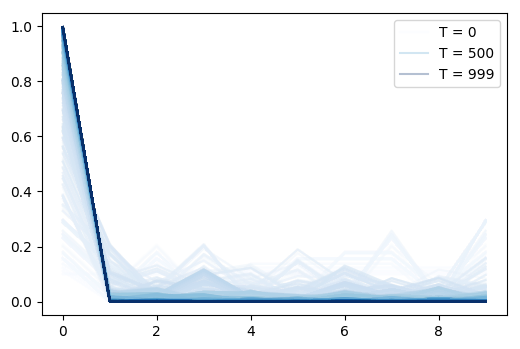

In [10]:
for j in range(TMax):
    if j in [0, int(np.floor(TMax/2)), TMax-1]:
        plt.plot(xHat[:, j], color=cmBlues[j], label='T = {}'.format(j))
    else:
        plt.plot(xHat[:, j], color=cmBlues[j])
plt.legend();

In [11]:
from mpl_toolkits.mplot3d import Axes3D

In [12]:
[nmesh, Tmesh] = np.meshgrid(range(nMax), range(TMax+1), indexing='ij')

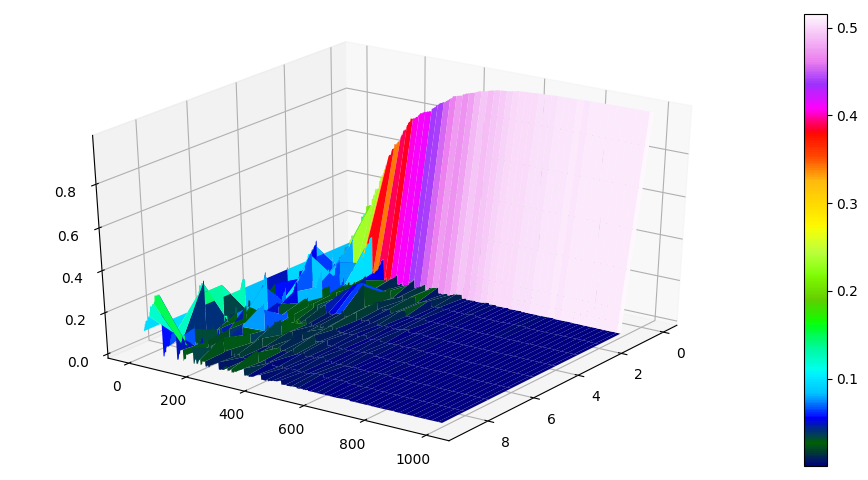

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
img = ax.plot_surface(nmesh, Tmesh, xHat, cmap=plt.cm.gist_ncar);
plt.colorbar(img);
ax.view_init(azim=35)

# Set-up

## Defining actions

There are five hazard rating levels:

     Hazard Rating Levels: 1,2,3,4,5

We will re-scale them

     Scaled HRL: 1/4, 2/4, 3/4, 4/4, 5/4

and use these to define our loss. We punish our learner's choice of action according to the true label of the example. The set of actions that our learner can take are `{C,1,2,3,4,5}`. The numerical values correspond with predicting the image's label and then querying the user for the true label; the `C` corresponds to choosing an image from the stream. The loss incurred by each action is defined according to the learner's performance on each classification, and is affected by how many choices it makes. 

    Loss function:
    
      Actual/  1    2    3    4    5
    Predicted
          1    0   1/4  1/2  3/4   1
          2   1/4   0   1/4  1/2  3/4
          3   1/2  1/4   0   1/4  1/2
          4   3/4  1/2  1/4  1/2  3/4
          5    1   3/4  1/2  3/4   1
          C   1/2  1/2  1/2  1/2  1/2

### Ideas for how to define the actions and their associated losses

Maybe we either need to:
* punish the learner for choosing something "less informative" 
* train the learner to select images of one category in batch 
    * if making a "choice" action is penalized, then perhaps the learner would decide to make fewer choice actions by labelling examples in batches.